# Which features determine Overall grade of FIFA18 players?

In [84]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Read the file

In [85]:
ATTRIBUTE_PATH =  "datasets/fifa18players/PlayerAttributeData.csv"
PERSONAL_PATH = "datasets/fifa18players/PlayerPersonalData.csv"

In [86]:
def load_player_data(att_path = ATTRIBUTE_PATH, personal_path = PERSONAL_PATH):
    att_data = pd.read_csv(att_path, dtype="str")
    pers_data = pd.read_csv(personal_path)
    return att_data, pers_data

pl_attributes, pl_personal = load_player_data()

## Prepare the dataset

In [87]:
atts = ["Name", "Age", "Nationality", "Overall", "Potential", "Club", "Value", "Wage"]

In [88]:
pl_attributes = pl_attributes.convert_objects(convert_dates=False, convert_numeric = True, convert_timedeltas = False)

c:\users\kuba\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [89]:
players = pd.concat([pl_personal[atts], pl_attributes], axis=1)
players = players.drop(["Unnamed: 0", "ID"], axis=1)
players.columns

Index(['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking',
       'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys'],
      dtype='object')

In [90]:
dot=["\."+ str(x) for x in range(1,10)]
dotM=["\."+ str(x) +"M" for x in range(1,10)]
dotK=["\."+ str(x) +"K" for x in range(1,10)]
no_dot=[str(x) for x in range(1,10)]
no_dotM=[str(x*100000) for x in range(1,10)]
no_dotK=[str(x*100) for x in range(1,10)]

players['Value']=players['Value'].replace( '€','', regex=True).replace(dotM,no_dotM,regex=True)\
                .replace(dotK,no_dotK,regex=True).replace(dot,no_dot,regex=True)\
                .replace('M','000000',regex=True).replace('K','000',regex=True)\
                .astype("int32")
players['Wage']=players['Wage'].replace( '€','', regex=True).replace(dotM,no_dotM,regex=True)\
                .replace(dotK,no_dotK,regex=True).replace(dot,no_dot,regex=True)\
                .replace('M','000000',regex=True).replace('K','000',regex=True)\
                .astype("int32")            

## Basic info about dataset

In [91]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 42 columns):
Name                  17981 non-null object
Age                   17981 non-null int64
Nationality           17981 non-null object
Overall               17981 non-null int64
Potential             17981 non-null int64
Club                  17733 non-null object
Value                 17981 non-null int32
Wage                  17981 non-null int32
Acceleration          17897 non-null float64
Aggression            17913 non-null float64
Agility               17910 non-null float64
Balance               17924 non-null float64
Ball control          17840 non-null float64
Composure             17887 non-null float64
Crossing              17885 non-null float64
Curve                 17908 non-null float64
Dribbling             17850 non-null float64
Finishing             17867 non-null float64
Free kick accuracy    17932 non-null float64
GK diving             17955 non-null float64
GK h

In [92]:
players.describe()

,Age,Overall,Potential,Value,Wage,Acceleration,Aggression,Agility,Balance,Ball control,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
count,17981.000000,17981.000000,17981.000000,1.798100e+04,17981.000000,17897.000000,17913.000000,17910.000000,17924.000000,17840.000000,...,17866.000000,17832.000000,17908.000000,17886.000000,17867.000000,17873.000000,17857.000000,17877.000000,17874.000000,17940.000000
mean,25.144541,66.247984,71.190813,2.385390e+06,11546.966242,64.576521,55.791492,63.333613,63.803894,58.071469,...,61.898802,58.263964,55.622292,45.496645,64.795713,63.233201,47.352187,65.279130,52.967495,43.198495
std,4.614272,6.987965,6.102199,5.353970e+06,23080.000139,14.918313,17.476572,14.802800,14.100950,16.834554,...,9.176709,14.947943,17.408483,21.489926,14.649127,15.942738,21.851023,12.618415,14.387015,17.734259
min,16.000000,46.000000,46.000000,0.000000e+00,0.000000,11.000000,11.000000,14.000000,11.000000,8.000000,...,28.000000,10.000000,3.000000,4.000000,11.000000,12.000000,4.000000,12.000000,10.000000,4.000000
25%,21.000000,62.000000,67.000000,3.000000e+05,2000.000000,56.000000,43.000000,55.000000,56.000000,53.000000,...,55.000000,53.000000,46.000000,23.000000,57.000000,56.000000,26.000000,58.000000,43.000000,30.000000
50%,25.000000,66.000000,71.000000,6.750000e+05,4000.000000,67.000000,59.000000,65.000000,66.000000,63.000000,...,62.000000,62.000000,59.000000,51.000000,67.000000,66.000000,54.000000,66.000000,54.000000,44.000000
75%,28.000000,71.000000,75.000000,2.100000e+06,12000.000000,75.000000,69.000000,74.000000,74.000000,69.000000,...,68.000000,68.000000,69.000000,64.000000,75.000000,74.000000,66.000000,74.000000,64.000000,57.000000
max,47.000000,94.000000,94.000000,1.230000e+08,565000.000000,96.000000,96.000000,96.000000,96.000000,95.000000,...,96.000000,92.000000,94.000000,91.000000,96.000000,95.000000,92.000000,98.000000,94.000000,91.000000


In [93]:
categories = list(set(players.columns) - set(players._get_numeric_data().columns))
categories

['Name', 'Nationality', 'Club']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189B10B9C50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000189B3D8DC88>]], dtype=object)

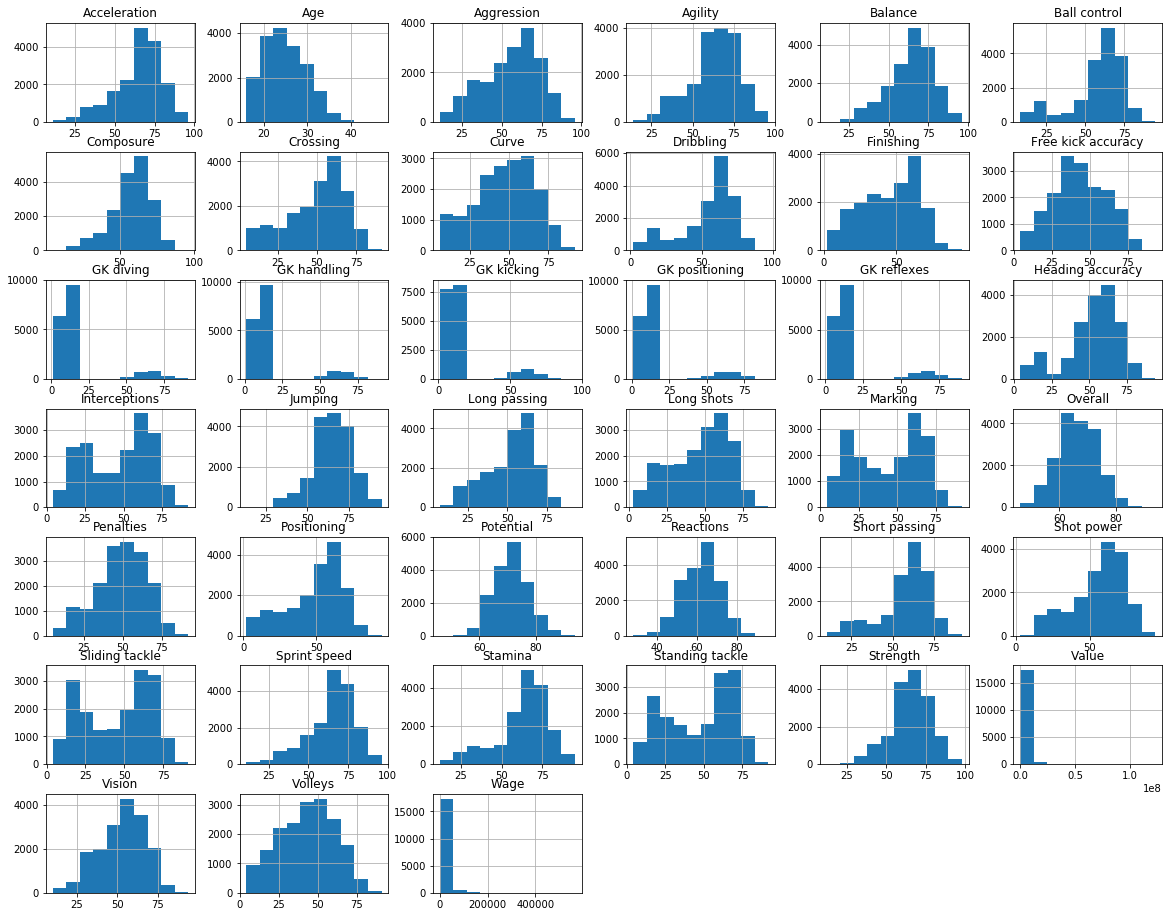

In [94]:
players.hist(figsize=(20,16))

In [95]:
players["Overall"].value_counts()

66    1105
67    1072
64    1056
68    1033
65    1015
63     917
69     908
70     905
71     841
62     814
72     715
60     689
61     681
73     676
74     579
59     501
58     456
75     454
57     377
76     370
56     314
77     293
55     288
54     255
78     230
53     227
79     175
52     174
51     131
80     127
50     115
82     101
81      93
83      71
49      49
84      35
48      23
85      23
86      23
47      16
88      14
87      13
46       8
89       8
90       5
92       3
94       1
91       1
93       1
Name: Overall, dtype: int64

## Train Test

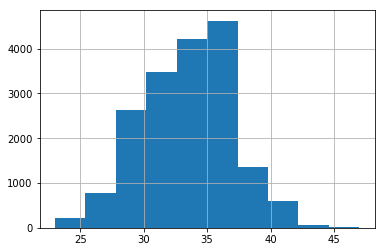

In [96]:
players["overall_groups"] = np.ceil(players["Overall"] / 2)
players["overall_groups"].hist()

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(players, players["overall_groups"]):
    strat_train_set = players.loc[train_index]
    strat_test_set = players.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("overall_groups", axis=1, inplace=True)

In [97]:
players = strat_train_set.copy()

## Fancy Scatter plot

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

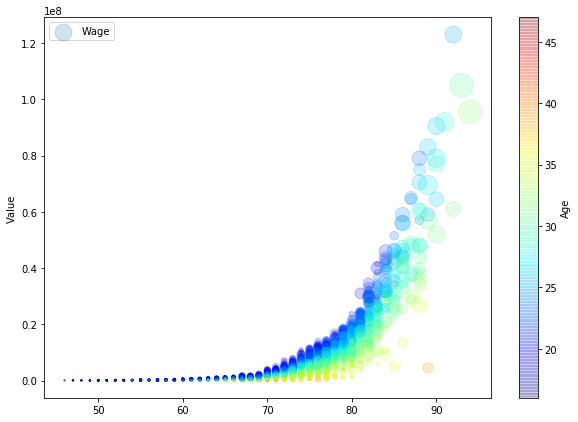

In [98]:
players.plot(kind="scatter", x="Overall", y="Value", alpha = 0.2,
             c="Age", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(10,7),
             s=players["Wage"]/1000, label="Wage")
axes=plt.gca()
plt.setp(axes.get_xticklabels(), visible=True)

## Correlations 

In [99]:
corr_matrix = players.corr()
corr_matrix["Overall"].sort_values(ascending = False)

Overall               1.000000
Reactions             0.841377
Potential             0.683604
Composure             0.626900
Value                 0.623527
Wage                  0.595350
Short passing         0.485818
Vision                0.479039
Long passing          0.470730
Age                   0.462124
Ball control          0.447455
Shot power            0.428000
Long shots            0.411914
Curve                 0.409297
Aggression            0.398749
Free kick accuracy    0.395019
Crossing              0.385771
Volleys               0.376707
Stamina               0.354713
Strength              0.354547
Dribbling             0.351645
Positioning           0.344678
Heading accuracy      0.342517
Penalties             0.331046
Interceptions         0.325030
Finishing             0.319687
Jumping               0.277531
Agility               0.261360
Standing tackle       0.249441
Marking               0.243343
Sprint speed          0.222042
Sliding tackle        0.217531
Accelera

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189B579FDD8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000189AE3279B0>]], dtype=object)

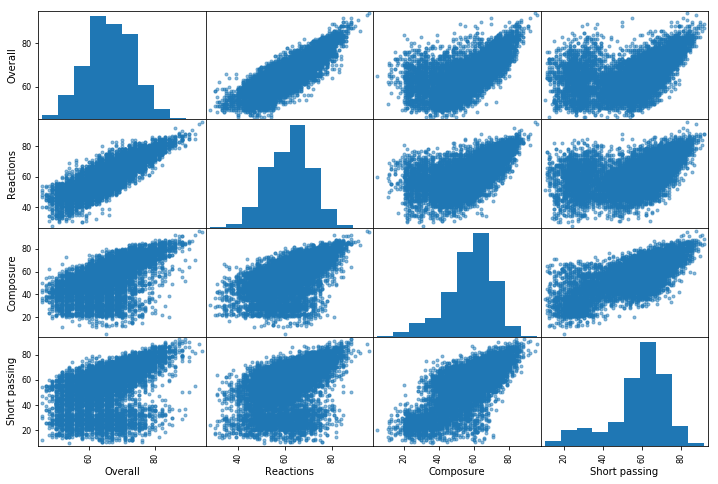

In [100]:
attribs = ["Overall", "Reactions", "Composure", "Short passing"]
scatter_matrix(players[attribs], figsize = (12,8))

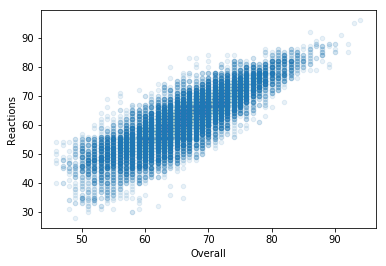

In [101]:
players.plot(kind="Scatter", x="Overall", y="Reactions", alpha=0.1)

## Pipelines

In [102]:
players_labels = players["Overall"].copy()
players = players.drop("Overall", axis=1)

In [103]:
players_num = players.drop(categories, axis=1)
players_cat = players[["Nationality", "Club"]]

In [104]:
players_cat.loc[players_cat['Club'].isnull(), 'Club'] = "free player"

c:\users\kuba\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\users\kuba\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [105]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [106]:
class NaNClubImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X.loc[X['Club'].isnull(), 'Club'] = "free player"
        return X
        #players_cat.loc[players_cat['Club'].isnull(), 'Club'] = "free player"

In [107]:
num_attribs = list(players_num)
cat_attribs = list(players_cat)

In [108]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy = "median")),
    ('std_scaler', StandardScaler())
])

cat_pipeline_nationality = Pipeline([
    ('selector', DataFrameSelector(["Nationality"])),
    ('label_binarizer', LabelBinarizer())
])

cat_pipeline_club = Pipeline([
    ('NaNImputer', NaNClubImputer()),
    ('selector', DataFrameSelector(["Club"])),
    ('label_binarizer', LabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline_nationality', cat_pipeline_nationality),
    ('cat_pipeline_club', cat_pipeline_club)
])

players_prepared = full_pipeline.fit_transform(players)

## Regression Models

### Linear Regression

In [109]:
lin_reg = LinearRegression()
lin_reg.fit(players_prepared, players_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [110]:
some_data = players.iloc[:5]
some_labels = players_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [ 61.81396484  70.81178284  60.97853088  68.06214142  68.67396545]
Labels:  [62, 70, 64, 68, 67]


c:\users\kuba\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [111]:
players_predictions = lin_reg.predict(players_prepared)
lin_mse = mean_squared_error(players_labels, players_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.7335795348913738

### Decision Tree Regressor

In [112]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(players_prepared, players_labels)

players_predictions = tree_reg.predict(players_prepared)
tree_mse = mean_squared_error(players_labels, players_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Random Forest Regressor

In [113]:
forest_reg = RandomForestRegressor()
forest_reg.fit(players_prepared, players_labels)

players_predictions = forest_reg.predict(players_prepared)
forest_mse = mean_squared_error(players_labels, players_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.21933607727461474

### Display models' scores

In [114]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())


In [115]:
tree_scores = cross_val_score(tree_reg, players_prepared, players_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [ 0.687423    0.70439896  0.6762115   0.68691736  0.65715279  0.59201925
  0.68105702  0.66242275  0.66189764  0.81876463]
Mean: 0.682826489178
Standard deviation 0.0536551267108


In [116]:
lin_scores = cross_val_score(lin_reg, players_prepared, players_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  3.43584549e+10   4.44279926e+09   1.45369751e+11   1.83986357e+00
   2.86693616e+10   3.35895950e+10   8.07128877e+09   1.05732320e+11
   5.65639637e+10   2.42857119e+10]
Mean: 44108324607.6
Standard deviation 44565798048.2


In [117]:
forest_scores = cross_val_score(forest_reg, players_prepared, players_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 0.60690949  0.4839107   0.46148384  0.49017448  0.4533065   0.44579631
  0.48547039  0.46440774  0.464535    0.62219607]
Mean: 0.497819053386
Standard deviation 0.0600057173837


### Search for the best parameters

In [118]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(players_prepared, players_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'max_features': [2, 3, 4], 'n_estimators': [3, 10], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [119]:
encoder_nationality = LabelBinarizer()
players_cat_1hot = encoder_nationality.fit_transform(players_cat["Nationality"])
encoder_club = LabelBinarizer()
players_cat_1hot = encoder_club.fit_transform(players_cat["Club"])

feature_importances = grid_search.best_estimator_.feature_importances_
attributes = num_attribs + list(encoder_nationality.classes_) + list(encoder_club.classes_)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.11297777172928072, 'Value'),
 (0.052182680957931028, 'Reactions'),
 (0.048411507187218664, 'Composure'),
 (0.045265225120610958, 'Ball control'),
 (0.038409064643307296, 'Wage'),
 (0.036313782197951457, 'Long passing'),
 (0.034400286106696883, 'Potential'),
 (0.034105180336115024, 'Short passing'),
 (0.032933289091112421, 'Vision'),
 (0.029452882185307779, 'Shot power'),
 (0.028944607439589806, 'Sliding tackle'),
 (0.026441700944624041, 'Aggression'),
 (0.026367559939249326, 'Standing tackle'),
 (0.024472009350075746, 'Long shots'),
 (0.023790661635502388, 'Interceptions'),
 (0.023303669139851661, 'Finishing'),
 (0.022113576515009285, 'Dribbling'),
 (0.019930562524606045, 'Age'),
 (0.019750019028143478, 'Curve'),
 (0.019620258031572087, 'GK positioning'),
 (0.019618281598338238, 'Positioning'),
 (0.01925728670459427, 'Marking'),
 (0.018907749008135924, 'Volleys'),
 (0.018214650689043075, 'Heading accuracy'),
 (0.016613889411915158, 'GK handling'),
 (0.015371364526058568, 'Free kick

## Final Model

In [120]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Overall", axis=1)
y_test = strat_test_set["Overall"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1.509643626132658